# Working With Tweets!
## After Hydrating Tweets (TwitterIDs --> Tweets) we Read in the JSON Objects to Work Directly With Tweets

In [1]:
import os
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import geopandas as gpd
from pygeocoder import Geocoder
import reverse_geocoder as rg 
import pprint

# -----------------------------------------------------------------------------------------------------
# <u>Read in JSON Files and Parse JSON</u>
# -----------------------------------------------------------------------------------------------------

In [5]:
# The JSON file has thousands of JSON objects in it, so we need to first open the file, 
# loop through each line, and use the json.loads() function to extract each object, which is one Tweet.
sample = 'some_april_tweets'
tweets = []
with open("twitter Data Sets\\GitHub Collected Data\\"+sample+".json") as f:
    for line in f:
        tweets.append(json.loads(line))

In [6]:
# How many tweets do we have in this JSON file
len(tweets)

86179

In [18]:
# What the available data looks like for one tweet
tweets[1]

{'created_at': 'Sat Feb 29 01:02:21 +0000 2020',
 'id': 1233558087572828161,
 'id_str': '1233558087572828161',
 'full_text': 'RT @Jordan_Sather_: Gates also said billions of dollars in funding is needed to work on a vaccine for the coronavirus.\n\nBillions of dollars…',
 'truncated': False,
 'display_text_range': [0, 140],
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [{'screen_name': 'Jordan_Sather_',
    'name': 'Jordan Sather',
    'id': 835627637049450497,
    'id_str': '835627637049450497',
    'indices': [3, 18]}],
  'urls': []},
 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 732249473057980417,
  'id_str': '732249473057980417',
  'name': 'Covfefe Chy ⏰⚖️💣',
  'screen_name': 'chardunbar2',
  'location': 'United States',
  'descripti

In [15]:
# How many variables are in this tweet in JSON form
w = str(tweets[1])
words = {}
for ws in w:
    if ws not in words:
        words[ws] = 1
    else:
        words[ws] += 1
print("There are {} keys (including nested keys) in this JSON object".format(words[':']))

There are 339 keys (including nested keys) in the JSON object


#### Note: The number of keys changes with each text because some Twitter profiles have more information, such as a background image, whether or not the tweet was in reply to another tweet, etc.

### Look at Text from Tweets

In [16]:
[print(tweets[i]['full_text'] +'\n') for i in range(5)]

RT @SamSacks: There’s a guy on MSNBC saying we most focus on three things to contain coronavirus. He called them “DTF”

Drug shortages
Test…

RT @Jordan_Sather_: Gates also said billions of dollars in funding is needed to work on a vaccine for the coronavirus.

Billions of dollars…

RT @acusapa: ini lokasi saat ini virus corona 
bisa di cek sendiri link nya. 🎉❤
https://t.co/F2XosLLeKV https://t.co/1Ir5CJYpkA

RT @HelenBranswell: 1. Americans should avoid all unessential travel to Italy and Iran, @CDCgov said late Friday. They join China &amp; South K…

RT @ELTIEMPO: Con el fin de conocer los protocolos de seguridad que implementan en el Aeropuerto El Dorado para la prevención del coronavir…



[None, None, None, None, None]

In [17]:
# If a Tweet was retweeted, the text may be shortened. For example, in this tweet below the 'full text'
# is actually cut short, but in the retweeted status we can see the full text.
print(tweets[27]['full_text']), tweets[27]['retweeted_status']['full_text']

RT @tobitac: We need a progressive narrative about coronavirus that centers not just Medicare for All and funding for public health, but al…


(None,
 'We need a progressive narrative about coronavirus that centers not just Medicare for All and funding for public health, but also antiracism and internationalism. The right is pushing racism and nationalism and a purely economic message won’t counter that #COVIDー19 (thread)')

# Filter by Locations to Include Only Washington and Florida
## This is a Two-Pronged Approach Because There are 2 Pieces of Information that Encode Locations. The First is a User-Defined Location, and the second is the Geo-Coordinates of the Tweet (most Tweets have geo-coordinates disabled).

### Filter Tweets by User-Defined Location

In [7]:
# Hand-code the locations of interest in each state (collection of cities with unique names)
locationsofinterest = ['seattle', 'spokane', 'tacoma', 'bellingham', 'tri cities', 'yakima', 'olympia',
                       'wa', 'washington state', 'seattle, wa', 'spokane, wa', 'tacoma, wa', 'bellingham, wa',
                       'tri cities, wa', 'yakima, wa', 'olympia, wa', 'seattle, washington', 'spokane, washington', 
                       'tacoma, washington', 'bellingham, washington', 'tri cities, washington', 'yakima, washington',
                       'olympia, washington',
                       'miami', 'tampa', 'tampa bay', 'jacksonville', 'orlando', 'fl', 'florida', 
                       'miama, fl', 'tampa, fl', 'tampba bay, fl', 'jacksonville, fl', ' orlando, fl', 
                       'miama, florida', 'tampa, florida', 'tampba bay, florida', 'jacksonville, florida',
                       ' orlando, florida']

In [8]:
# Select only Tweets that have a user-defined location in our 'locationsofinterest' list
valid_locs_location = [tweets[i]['user']['location'].lower().replace('\n', ' ').replace('\t', ' ').replace(r"[^\w\s']",' ').strip() 
                       in locationsofinterest for i in range(len(tweets))]
valid_tweets_location = list(pd.Series(tweets)[valid_locs_location])

### Filter Tweets by Geo-Coordinates Using Reverse GeoCoding

In [9]:
# Function to Reverse GeoCode the coordinates to see if they are in Washington or Florida
def reverseGeocode(coordinates): 
    result = rg.search(coordinates)
    return result

In [10]:
# Select only Tweets that have Geo-Coordinates
valid_locs_coords = [tweets[i]['coordinates'] != None for i in range(len(tweets))]
valid_tweets_coords = list(pd.Series(tweets)[valid_locs_coords])

In [11]:
# Get a Tuple of all Geo-Coordinates to pass into the reverseGeocode function
tuplecoords = [(valid_tweets_coords[i]['coordinates']['coordinates'][1], valid_tweets_coords[i]['coordinates']['coordinates'][0]) 
               for i in range(len(valid_tweets_coords))]

In [12]:
# As a check, see where all valid tweet geo-coordinates are located
geometry = [Point(xy) for xy in zip([valid_tweets_coords[i]['coordinates']['coordinates'][0] for i in range(len(valid_tweets_coords))],
                                    [valid_tweets_coords[i]['coordinates']['coordinates'][1] for i in range(len(valid_tweets_coords))])]
geodf = gpd.GeoDataFrame(geometry, columns = ['geometry'])

It looks like only 1 tweet is in Florida, and 0 are in Washington,
so we should only capture one tweet


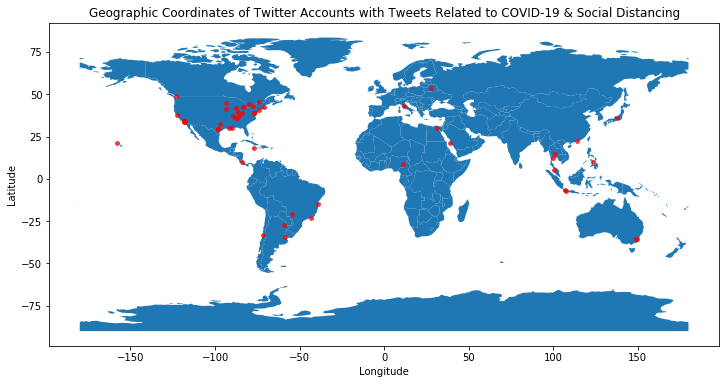

In [13]:
# Plot the points!
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

geodf.plot(ax=world.plot(figsize=(12,12)), marker = 'o', color = 'red', markersize = 15, alpha = .7)  
plt.title('Geographic Coordinates of Twitter Accounts with Tweets Related to COVID-19 & Social Distancing')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
print("It looks like only 1 tweet is in Florida, and 0 are in Washington,\nso we should only capture one tweet")

In [14]:
# Store the place location of all the geo-coordinates
result = []
for i in range(len(valid_tweets_coords)):
    result.append(reverseGeocode(tuplecoords[i]))

Loading formatted geocoded file...


In [22]:
# Use the 'admin1' variable from the reverseGeocode to determine the U.S. State of the tweet
state = []
for i in range(len(result)):
    state.append(result[i][0]['admin1'])

In [23]:
# Pick out the indices of the Tweets if the state is Florida or Washington
flindices = [i for i, x in enumerate(state) if x == "Florida"]
waindices = [i for i, x in enumerate(state) if x == 'Washington']

In [35]:
print("List of Tweet indices associated with Florida: {}\nList of Tweet indices associated with Washington: {}".
      format(flindices, waindices))

List of Tweet indices associated with Florida: [65]
List of Tweet indices associated with Washington: []


#### We only have 1 valid tweet this time, which matches what we saw from the map.

In [36]:
# Combine the indices from Florida and Washington into one list
valid_florida = list(pd.Series(valid_tweets_coords)[flindices])
valid_washington = list(pd.Series(valid_tweets_coords)[waindices])
valid_fl_or_wa = valid_florida + valid_washington

### Combine all Valid Tweets, Select Only Relevant Variables, Convert to DataFrame, and Store Output as CSV

In [40]:
# Further combine all valid geo-coordinates with all of the valid user-defined locations
all_valid_tweets = valid_tweets_location+valid_fl_or_wa

In [41]:
# Each Tweet has 163 variables but we really only need a few; Date created, text of tweet, retweeted text if available,
# the location and coordinates
created_at = [all_valid_tweets[i]['created_at'] for i in range(len(all_valid_tweets))]
full_text = [all_valid_tweets[i]['full_text'] for i in range(len(all_valid_tweets))]
userid = [all_valid_tweets[i]['user']['id'] for i in range(len(all_valid_tweets))]
location = [all_valid_tweets[i]['user']['location'] for i in range(len(all_valid_tweets))]
coordinates = [all_valid_tweets[i]['coordinates'] for i in range(len(all_valid_tweets))]
retweeted_text = []
for i in range(len(all_valid_tweets)):
    try:
        retweeted_text.append(all_valid_tweets[i]['retweeted_status']['full_text'])
    except:
        retweeted_text.append('n/a')

In [42]:
# Store the selected variables in a dataframe
output = pd.DataFrame({'created_at':created_at,'full_text':full_text,'userid':userid,'location':location,
             'coordinates':coordinates,'retweeted_text':retweeted_text})
output.head()

,created_at,full_text,userid,location,coordinates,retweeted_text
0,Sat Feb 29 01:54:26 +0000 2020,RT @LRinaldiArt: The coronavirus outbreak has ...,8889522,"Spokane, WA",None,The coronavirus outbreak has me thinking back ...
1,Sat Feb 29 01:08:55 +0000 2020,RT @Barton_options: A gentle reminder of the c...,287394890,Florida,None,A gentle reminder of the consequence of severe...
2,Sat Feb 29 01:46:17 +0000 2020,RT @SenSanders: Senator McConnell: Do not play...,3220025137,"Seattle, WA",None,Senator McConnell: Do not play politics with o...
3,Sat Feb 29 01:38:44 +0000 2020,RT @AnnieGabstonH: President Trump says that w...,496536747,Florida,None,President Trump says that we have nothing to w...
4,Sat Feb 29 01:36:27 +0000 2020,@Cernovich ... and I thought I was being slick...,248742164,"Tampa, FL",None,n/a


In [ ]:
# Save the valid tweets that will later be used for analysis as a csv file
output.to_csv("C:\\Users\\John\Desktop\\MSIM\\Spring Quarter 2020\\IMT 575\\Group Project\\twitter data sets\\CsvOutputs\\"+sample+".csv",
             encoding='utf-8', index=False)